# DOE analysis

## Quick check and preprocessing

In [2]:
import pandas as pd

# 読み込み（添付ファイル名に合わせる）
df = pd.read_csv("../logs/result_20251201162005.csv")

# 因子をカテゴリ化（ANOVAでの安定・明示のため）
factor_cols = ["PERIOD_MA_1", "PERIOD_MA_2", "PERIOD_MR", "THRESHOLD_MR"]
for c in factor_cols:
    df[c] = df[c].astype("category")

# 応答の型チェック
df["total"] = pd.to_numeric(df["total"], errors="coerce")

# レプリケート（日付）をブロックとして持たせたい場合の候補列
# date_str が実質ブロック要因になり得る
df["date_str"] = df["date_str"].astype("category")

display(df.head())
print("N rows:", len(df))
print("Levels:")
for c in factor_cols:
    print(c, list(df[c].cat.categories))

,file,code,trade,PERIOD_MA_1,PERIOD_MA_2,PERIOD_MR,THRESHOLD_MR,total
0,ticks_20251127.xlsx,7011,100,30,300,15,1,-37.0
1,ticks_20251128.xlsx,7011,100,30,300,15,1,17.0
2,ticks_20251201.xlsx,7011,100,30,300,15,1,47.0
3,ticks_20251127.xlsx,7011,100,60,300,15,1,-68.0
4,ticks_20251128.xlsx,7011,100,60,300,15,1,-52.0


N rows: 243
Levels:
PERIOD_MA_1 [30, 60, 90]
PERIOD_MA_2 [300, 600, 900]
PERIOD_MR [15, 30, 45]
THRESHOLD_MR [1, 4, 7]


## ANOVA (main effects and interactions)

In [3]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

# まずはブロック抜きのフルモデル（主効果＋全交互作用）
model = ols(
    "total ~ C(PERIOD_MA_1) * C(PERIOD_MA_2) * C(PERIOD_MR) * C(THRESHOLD_MR)",
    data=df
).fit()

anova_table = sm.stats.anova_lm(model, typ=2)
display(anova_table)

# 参考：ブロック（date_str）を加えたモデル（交互作用は因子間のみ）
model_blk = ols(
    "total ~ C(date_str) + C(PERIOD_MA_1) * C(PERIOD_MA_2) * C(PERIOD_MR) * C(THRESHOLD_MR)",
    data=df
).fit()

anova_table_blk = sm.stats.anova_lm(model_blk, typ=2)
display(anova_table_blk)

# モデル要約
print(model.summary())

,sum_sq,df,F,PR(>F)
C(PERIOD_MA_1),304.617284,2.0,0.221452,8.015968e-01
C(PERIOD_MA_2),21292.617284,2.0,15.479378,7.048430e-07
C(PERIOD_MR),4732.518519,2.0,3.440462,3.441025e-02
C(THRESHOLD_MR),39428.222222,2.0,28.663661,2.198895e-11
C(PERIOD_MA_1):C(PERIOD_MA_2),743.876543,4.0,0.270393,8.967067e-01
C(PERIOD_MA_1):C(PERIOD_MR),175.382716,4.0,0.063750,9.924539e-01
C(PERIOD_MA_2):C(PERIOD_MR),199.456790,4.0,0.072501,9.903545e-01
C(PERIOD_MA_1):C(THRESHOLD_MR),2123.679012,4.0,0.771940,5.449418e-01
C(PERIOD_MA_2):C(THRESHOLD_MR),8850.641975,4.0,3.217135,1.424713e-02
C(PERIOD_MR):C(THRESHOLD_MR),1484.444444,4.0,0.539583,7.068609e-01


,sum_sq,df,F,PR(>F)
C(file),26611.432099,2.0,25.102786,3.296559e-10
C(PERIOD_MA_1),304.617284,2.0,0.287348,7.506369e-01
C(PERIOD_MA_2),21292.617284,2.0,20.085503,1.650079e-08
C(PERIOD_MR),4732.518519,2.0,4.464224,1.298300e-02
C(THRESHOLD_MR),39428.222222,2.0,37.192971,5.433428e-14
C(PERIOD_MA_1):C(PERIOD_MA_2),743.876543,4.0,0.350852,8.431532e-01
C(PERIOD_MA_1):C(PERIOD_MR),175.382716,4.0,0.082720,9.876139e-01
C(PERIOD_MA_2):C(PERIOD_MR),199.456790,4.0,0.094075,9.842227e-01
C(PERIOD_MA_1):C(THRESHOLD_MR),2123.679012,4.0,1.001642,4.084704e-01
C(PERIOD_MA_2):C(THRESHOLD_MR),8850.641975,4.0,4.174442,3.044972e-03


                            OLS Regression Results                            
Dep. Variable:                  total   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     1.531
Date:                Tue, 02 Dec 2025   Prob (F-statistic):             0.0116
Time:                        08:09:54   Log-Likelihood:                -1089.4
No. Observations:                 243   AIC:                             2341.
Df Residuals:                     162   BIC:                             2624.
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
                                                                                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

## Mean effects by factor level

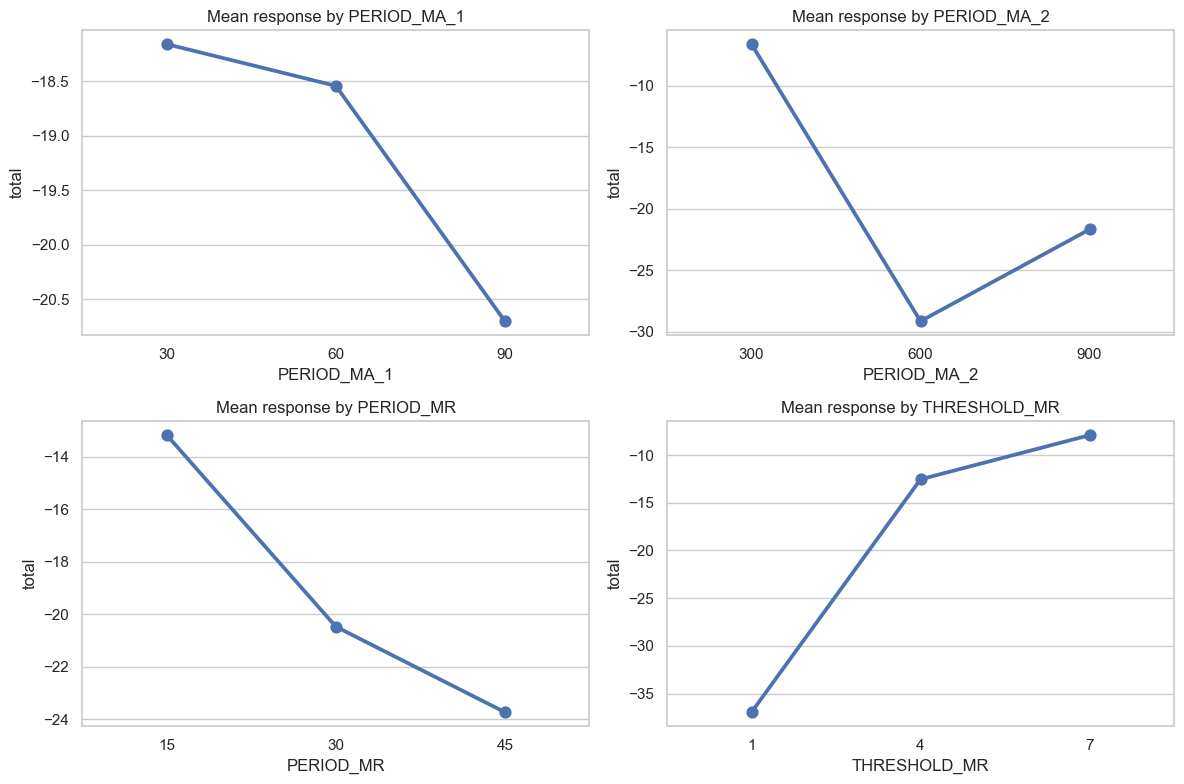

,PERIOD_MA_1,PERIOD_MA_2,PERIOD_MR,THRESHOLD_MR,mean,std,count
0,30,300,15,1,9.000000,42.567593,3
1,30,300,15,4,1.666667,28.431204,3
2,30,300,15,7,-4.666667,5.131601,3
3,30,300,30,1,0.333333,29.484459,3
4,30,300,30,4,-7.666667,24.214321,3
5,30,300,30,7,-9.000000,20.663978,3
6,30,300,45,1,0.333333,29.484459,3
7,30,300,45,4,-2.666667,29.022979,3
8,30,300,45,7,-11.333333,28.219379,3
9,30,600,15,1,-48.000000,20.074860,3


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for ax, col in zip(axes.flatten(), factor_cols):
    # seabornの新仕様に合わせて errorbar=None を使用
    sns.pointplot(x=col, y="total", data=df, ax=ax, errorbar=None)
    ax.set_title(f"Mean response by {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("total")

plt.tight_layout()
plt.show()

# 参考：水準別の記述統計を表で確認
#desc = df.groupby(factor_cols)["total"].agg(["mean", "std", "count"]).reset_index()
desc = (
    df.groupby(factor_cols, observed=True)["total"]
      .agg(["mean", "std", "count"])
      .reset_index()
)
display(desc.head(12))

## Interaction inspection (selected pairs)

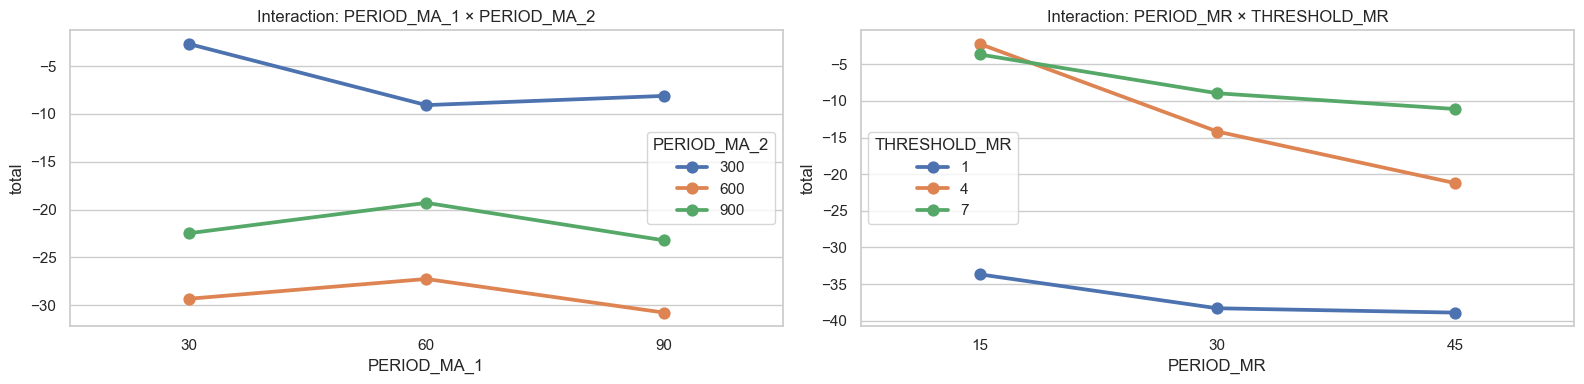

In [6]:
# 代表的なペア：MA期間同士、MA×MR
pairs = [
    ("PERIOD_MA_1", "PERIOD_MA_2"),
    ("PERIOD_MR", "THRESHOLD_MR"),
]

fig, axes = plt.subplots(1, len(pairs), figsize=(16, 4))
for ax, (a, b) in zip(axes, pairs):
    sns.pointplot(x=a, y="total", hue=b, data=df, ax=ax, errorbar=None)
    ax.set_title(f"Interaction: {a} × {b}")
    ax.set_xlabel(a)
    ax.set_ylabel("total")

plt.tight_layout()
plt.show()